---
title: "Roots I"
subtitle: "Nonlinear Equation in One Variable"
format: 
  html:
    toc: true
    code-fold: false
    page-layout: full
    fig-cap-location: bottom
    number-sections: true
    number-depth: 2
    html-to-math: katex
    html-math-method: katex
    callout-appearance: minimal
jupyter: python3
---

# Motivation
## Examples from Physics
Let us consider a few examples in Physics. 

### Van der Waals equation of state
As you may recall, the classical ideal gas "law" has the form:
$$
Pv = RT
$$
where $P$ is the pressure, $v$ is the molar volume, $R$ is the gas constant, and $T$ is the temperature. 

This ignores the finite size of the gas molecules, as well as the mutual attraction between molecules. Correcting for these features "by hand" (or via the formalism of statistical mechanics) leads to the so-called _van der Waals equation of state_:
$$
(P + \frac{a}{v^2})(v-b) = RT,
$$
where $a$ and $b$ are the parameters that depend on the gas. Assume you know the pressure and the temperature and wish to evaluate the molar volume. As you can see by multiplying this equation with $v^2$, you get a cubic equation in $v$. Although cubic equation can still be solved analytically, you can consider even more complicated but realistic models. Then you have to use numerical methods to find solutions. 

### Quantum mechanics of a particle in a finite well
In the problem of finding eigenstates of a single particle restricted in a finite square well potential, we will encounter such a transcendental equation
$$
k\tan ka = \kappa,
$$
where $k$, $a$ and $\kappa$ are parameters of the system. If we want to solve for $k$ given $a$ and $\kappa$, we have to take the numerical approach.

## The Problem(s) to Be Solved
At its most basic level, the problem we are faced with is as follows: you are given a function $f(x)$ and you need to find its zeros. In other words, you need to solve the equation $f(x)=0$ (the solutions of this equation are known as _roots_). Thus, our task is to solve:
$$
f(x) = 0,
$$
where $f(x)$ is generally nonlinear.The $f(x)$ involved may be a polynomial, a special function, 
or a complicated programming routine (which makes each
function evaluation quite costly). In what follows, we will denote our root by $x^*$.

To give an example: $f(x) = x^2 - 5 = 0$ is very easy to write down. Anyone can "solve" it by saying $x^2 = 5$ followed by $x = \pm\sqrt{5}$.
This is where things are not so easy any more: what is the value of $\sqrt{5}$ ?
You can use a calculator, or use python built-in function `sqrt`. But how do these tools figure out which number gives 5 when squared?
We will encounter several general-use methods later to find out the answer.

A complication arises when you are faced with a single polynomial and need to evaluate its zeros. In equation form
$$
c_0 + c_1 x + \cdots + c_{n-1}x^{n-1} = 0.
$$
This is a single equation, but it has $n-1$ roots.

A more complicated version of the earlier problem (one nonlinear equation in one variable) is the case where we have $n$ simultaneous nonlinear equations $n$ unknowns:
$$
\begin{cases}
f_{0}(x_{0},x_{1,}\dots,x_{n-1}) & =0\\
f_{1}(x_{0},x_{1,}\dots,x_{n-1}) & =0\\
 & \vdots\\
f_{n-1}(x_{0},x_{1},\dots,x_{n-1}) & =0
\end{cases}
$$
which can be recast using our vector notation
$$
\boldsymbol{f(x) = 0}.
$$

The final problem we attack on this topic is related yet distinct: instead of trying to find the zeros of a function, find the points where the function attains a minimum (or, as we will see, a maximum). Using the notation we introduced above, this problem would have the form:
$$
\min \phi(\boldsymbol{x})
$$
where $\boldsymbol{x} = (x_0, x_1, \dots, x_{n-1})$, and $\phi$ is a function producing scalar values. 

# Nonlinear Equation in One Variable 
Let us consider a concrete problem, solving
$$
e^{x-\sqrt{x}} - x = 0.
$$

Most simply, we can find out the roots by plotting the function.

Text(0, 0.5, 'f(x)')

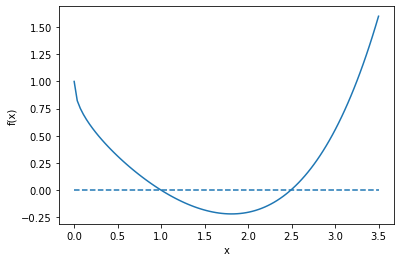

In [2]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0,3.5,100)
fx = np.exp(x - np.sqrt(x)) - x
plt.plot(x,fx,'-')
plt.hlines(y=0,xmin=0,xmax=3.5,ls='--')
plt.xlabel('x')
plt.ylabel('f(x)')

We see that our function has two zeros, one near $x^*\simeq 1$ and another one near $x^∗ \simeq 2.5$. 
We can check that $x^*=1$ is indeed a root. 

Now, turning to ways of solving our equation: we'll need a method that can find both roots, preferably in comparable amounts of time. (While we already analytically know one of the roots, we'll keep things general.) The most naive approach, having already plotted the function, is to try out different values (or perhaps even a very fine grid) near where we expect the roots to be. This is not a great idea, for several reasons: 

1. It is very wasteful, requiring a large number of function evaluations. What do you do if the first grid spacing you chose was not fine enough? You pick a smaller grid spacing and start evaluating the function again. 
2. As noted in the previous section, in some cases even evaluating the function a single time may be very costly, so you might not even be able to plot the function in the first place. 
3. It is easy to see that this brute-force approach will immediately fail when you are faced with a multidimensional problem (since you’d need a multidimensional grid, with costly function evaluations at each point on the grid). 
   
At a big-picture level, we can divide root-finding methods into two large classes:

- **Bracketing methods**: these are approaches which start with two values of $x$, let us call them $x_0$ and $x_1$, which bracket the root (i.e., we already know that $f(x_0)$ and $f(x_1)$ have opposite signs). Of the methods we discuss below, _bisection_ and _Ridders'_ are bracketing methods.
- **Non-bracketing methods**: also known as open-domain methods: these approaches may need one or two starting estimates of the root, but the root itself does not need to be bracketed in the first place. Of the methods introduced below, _fixed-point iteration_, _Newton's_, and the _secant_ methods are all non-bracketing.

While the distinction between bracketing and non-bracketing methods is very important and should always be borne in mind when thinking about a given approach, we will not introduce these methods in that order. Instead, we will employ a pedagogical approach, starting with simple methods first (which end up being very slow) and increasing the sophistication level as we go.

## Conditioning
When discussing solving systems of linear equations, $\boldsymbol{A}\boldsymbol{x} = \boldsymbol{b}$, we encountered the question of how $\boldsymbol{x}$ is impacted when we slightly perturb $\boldsymbol{A}$. This led us to introduce the condition number $\kappa(\boldsymbol{A})$ as a measure of how much (or how little) a perturbation in the coefficient matrix, $\|\Delta \boldsymbol{A} \|/\|\boldsymbol{A}\|$, is amplified when evaluating the effect on the solution vector, $\|\Delta \boldsymbol{x}\|/\| \boldsymbol{x}\|$.

We will now do something analogous, this time for the case of absolute changes. The problem we are now solving is the nonlinear equation $f(x) = 0$, so the perturbations in the system would be perturbations of the value of the function $f$.

To be specific, the exact root is denoted by $x^*$, and the approximate value for it is denoted as $\tilde{x}^*$.
What we'll do is to Taylor expand $f(\tilde{x}^*)$ around $x^*$. This gives us:
$$
f(\tilde{x}^*) - f(x^*) = f(x^* + \Delta x^*) - f(x^*) \simeq   f'(x^*)\Delta x^*,
$$
where $\Delta x^* = \tilde{x}^* - x^*$. 

This implies
$$
\Delta x^* \simeq \frac{1}{f'(x^*)}[f(\tilde{x}^*) - f(x^*)],
$$
which allows us to introduce a _condition number_ for our problem:
$$
\kappa_f = \frac{1}{f'(x^*)}.
$$

Thus, a larger $f'(x^*)$ gives a small $\kappa_f$, indicating a _well-conditioned_ problem.

##  Order of Convergence and Termination Criteria
Our goal is to find an $x^∗$ such that $f(x^∗) = 0$.  Except for very low-degree polynomials, this is a problem that does not have an analytical solution with a closed formula. In practice, we have to resort to _iterative methods_. For these iterative methods, we have to first have an initial root estimate $x^{(0)}$. 

We will have a sequence of iterates, $x^{(0)}, x^{(1)}, x^{(2)}, \cdots, x^{(k)}$ which will be approaching $x^*$. Let us assume that we are dealing with a convergent method and that $x^{(k)}$ will be close to the root $x^*$. We shall discuss the meaning "close" below.

If there exist a constant $m\neq 0$ and a number $p$ such that:
$$
|x^{(k)} - x^*| \leq m |x^{(k-1)} - x^*|^p
$$
for $k$ sufficiently large, then $m$ is called the _asymptotic error constant_ and $p$ is called the _order of convergence_. 

- If $p = 1$ then we are dealing with a _linearly convergent_ method (e.g. fixed-point iteration). 
- If $p = 2$ then we have a _quadratically convergent_ method (e.g. Newton's method).
- Non-integer $p \simeq 1.618$, such as secant method, which is _superlinearly convergent_.

Practically, one can use another test for convergence
$$
\frac{|x^{(k)} - x^{(k-1)}|}{|x^{(k)}|}\leq \epsilon.
$$
Sometimes, $x^{(k)}$ may be small, then we may use
$$
\frac{|x^{(k)} - x^{(k-1)}|}{1+|x^{(k)}|}\leq \epsilon
$$
as a convergence criterion.

## Fixed-point iteration
### Algorithm
This algorithm solves the following problem
$$
x = g(x).
$$
A point $x^*$ satisfying the above relation is called a _fixed point_ of $g$.

- $g(x) = x^2 - 6$ has two fixed points: $x^* = 3$ and $x^* = -2$.
- $g(x) = x + 2$ has no fixed point.

The algorithm is:

1. Starting from an initial estimate $x^{(0)}$
2. Compute 
   $$
   x^{(1)} = g(x^{(0)})
   $$ 
3. Iterate this procedure, with
   $$
   x^{(k)} = g(x^{(k-1)}).
   $$

### Implementation
Let us consider the problem $g(x) = e^{x - \sqrt{x}}$.

In [3]:
import numpy as np

def g(x):
    return np.exp(x - np.sqrt(x))

def fixedpoint(g,xold,kmax=200,tol=1.e-8):
    for k in range(1,kmax):
        xnew = g(xold)

        xdiff = xnew - xold
        print("{0:2d} {1:1.16f} {2:1.16f}".format(k,xnew,xdiff))

        if abs(xdiff/xnew) < tol:
            break
        xold = xnew
    else:
        xnew = None
    return xnew

if __name__ == '__main__':
    for xold in (0.99, 2.499):
        x = fixedpoint(g,xold)
        print(x)

 1 0.9950249795068901 0.0050249795068901
 2 0.9975186749161311 0.0024936954092410
 3 0.9987608763846132 0.0012422014684821
 4 0.9993808220095828 0.0006199456249696
 5 0.9996905068451969 0.0003096848356141
 6 0.9998452773684844 0.0001547705232875
 7 0.9999226446689382 0.0000773673004538
 8 0.9999613238304214 0.0000386791614831
 9 0.9999806622891710 0.0000193384587497
10 0.9999903312380722 0.0000096689489012
11 0.9999951656424073 0.0000048344043351
12 0.9999975828270463 0.0000024171846390
13 0.9999987914149838 0.0000012085879375
14 0.9999993957078571 0.0000006042928733
15 0.9999996978540199 0.0000003021461628
16 0.9999998489270328 0.0000001510730129
17 0.9999999244635221 0.0000000755364894
18 0.9999999622317625 0.0000000377682403
19 0.9999999811158816 0.0000000188841192
20 0.9999999905579409 0.0000000094420592
0.9999999905579409
 1 2.5047211959255882 0.0057211959255881
 2 2.5145405344896088 0.0098193385640206
 3 2.5314955389430209 0.0169550044534121
 4 2.5610776263207149 0.02958208737769

C:\Users\pengy\AppData\Local\Temp\ipykernel_16604\827739561.py:4: RuntimeWarning: overflow encountered in exp
  return np.exp(x - np.sqrt(x))
C:\Users\pengy\AppData\Local\Temp\ipykernel_16604\827739561.py:13: RuntimeWarning: invalid value encountered in double_scalars
  if abs(xdiff/xnew) < tol:
C:\Users\pengy\AppData\Local\Temp\ipykernel_16604\827739561.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return np.exp(x - np.sqrt(x))


Note that we get $x^* = 1$ successfully. However, the other fixed point $x^*\simeq 2.5$ can not be found even if we started at $2.499$. 

Now, if we take $x = e^{x-\sqrt{x}}$ and rewrite it as $\ln x = x - \sqrt{x}$, or $x = \ln x + \sqrt{x}$, we can take $g(x) = \ln x + \sqrt{x}$. The fixed point of this $g(x)$ can be calculated below. 

In [4]:
import numpy as np

def g(x):
    return np.log(x) + np.sqrt(x)

def fixedpoint(g,xold,kmax=200,tol=1.e-8):
    for k in range(1,kmax):
        xnew = g(xold)

        xdiff = xnew - xold
        print("{0:2d} {1:1.16f} {2:1.16f}".format(k,xnew,xdiff))

        if abs(xdiff/xnew) < tol:
            break
        xold = xnew
    else:
        xnew = None
    return xnew

if __name__ == '__main__':
    for xold in (0.99, 2.499):
        x = fixedpoint(g,xold)
        print(x)

 1 0.9849371012531185 -0.0050628987468815
 2 0.9772624771823942 -0.0076746240707243
 3 0.9655658621701254 -0.0116966150122688
 4 0.9475911454393494 -0.0179747167307760
 5 0.9196107829003974 -0.0279803625389520
 6 0.8751586292403727 -0.0444521536600248
 7 0.8021490152512132 -0.0730096139891595
 8 0.6751668375278304 -0.1269821777233828
 9 0.4288899121282286 -0.2462769253996017
10 -0.1916581367026353 -0.6205480488308639
11 nan nan
12 nan nan
13 nan nan
14 nan nan
15 nan nan
16 nan nan
17 nan nan
18 nan nan
19 nan nan
20 nan nan
21 nan nan
22 nan nan
23 nan nan
24 nan nan
25 nan nan
26 nan nan
27 nan nan
28 nan nan
29 nan nan
30 nan nan
31 nan nan
32 nan nan
33 nan nan
34 nan nan
35 nan nan
36 nan nan
37 nan nan
38 nan nan
39 nan nan
40 nan nan
41 nan nan
42 nan nan
43 nan nan
44 nan nan
45 nan nan
46 nan nan
47 nan nan
48 nan nan
49 nan nan
50 nan nan
51 nan nan
52 nan nan
53 nan nan
54 nan nan
55 nan nan
56 nan nan
57 nan nan
58 nan nan
59 nan nan
60 nan nan
61 nan nan
62 nan nan
63 nan 

C:\Users\pengy\AppData\Local\Temp\ipykernel_16604\158291069.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(x) + np.sqrt(x)
C:\Users\pengy\AppData\Local\Temp\ipykernel_16604\158291069.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.log(x) + np.sqrt(x)


In this new program, $x^* \simeq 2.5$ is found successfully, but not the other. 

### Convergence properties
From $x^{(k)} = g(x^{(k-1)})$ and $x^* = g(x^*)$, we have
$$
x^{(k)} - x^* = g(x^{(k-1)})  - g(x^*) = g'(\xi)(x^{(k-1)} - x^*),
$$
with some $\xi$ between $x^{(k-1)}$ and $x^*$.
If $|g'(\xi)|\leq m <1$, we will have
$$
|x^{(k) - x^*}| \leq m |x^{(k-1)} - x^*| \leq m^2 |x^{(k-2)} - x^*| \leq \dots \leq m^k|x^{(0)} - x^*|.
$$

Let us first consider $g(x) = e^{x - \sqrt{x}}$. We have
$$
g'(x^*) = (1 -\frac{1}{2\sqrt{x^*}})x^* = x^* - \frac{\sqrt{x^*}}{2}.
$$
For $x^*=1$, we have $g'(x^*)= \frac{1}{2}<1$, indicating near $x^*=1$ the method is convergent.
For $x^*\simeq 2.5$, $g'(x^*)>1$, that's why the method is not convergent.

## Bisection method
The problem of the fixed-point iteration is that the mapping from $f(x) = 0$ to $x = g(x)$ is not unique. Also, if $g'(\xi) >1 $, the fixed-point iteration method diverges. It would be nice to have a more stable method. This is precisely what the bisection method accomplishes; it is a slow method, which doesn't really generalize to higher-dimensional problems, but it is safe and systematic.

### Algorithm and Convergence
The bisection method assumes you have already bracketed the root; that means that you have found an x0 and an x1 for which $f(x_0)$ and $f(x_1)$ have opposite signs. 
The algorithm:

- Take the interval $(x_0, x_1)$ (for which we know $f(x_0)f(x_1) < 0$) and evaluate the midpoint:
  $$
  x_2 = \frac{x_0 + x_1}{2}
  $$
- We are producing two subintervals: $(x_0, x_2)$ and $(x_2, x_1)$. The sign of $f(x_2)$ will determine in which of these two subintervals the root lies.
- If $f(x_0)f(x_2) < 0$, then the root is in $(x_0, x_2)$. Thus, we could rename $x_1 \leftarrow x_2$ and repeat the entire process (which started with an $x_0$ and an $x_1$ that bracket the root).
- If $f(x_0)f(x_2)>0$, then the root is in $(x_2, x_1)$. Thus, we could rename $x_0 \leftarrow x_2$ and repeat the entire process. 

Let us denote $x^{(k)}$ as the midpoint obtained in the $k$th step. Let us denote the initial interaval as $(a,b)$, we have
$$
|x^{(k)} - x^*| \leq \frac{b-a}{2^{k+1}}
$$

For each order higher in $k$, we get an additional factor of $1/2$, and thus the bisection method gives _linear convergence_.

### Implementation
We will use the termination criterion
$$
\frac{|x^{(k)} - x^{(k-1)}|}{|x^{(k)}|}\leq \epsilon 
$$

In [5]:
import numpy as np

def f(x):
    return np.exp(x - np.sqrt(x)) - x

def bisection(f,x0,x1,kmax=200,tol=1.e-8):
    f0 = f(x0)
    for k in range(1,kmax):
        x2 = (x0+x1)/2
        f2 = f(x2)
        
        if f0*f2 < 0:
            x1 = x2
        else:
            x0, f0 = x2, f2
            
        x2new = (x0+x1)/2
        xdiff = np.abs(x2new-x2)
        rowf = "{0:2d} {1:1.16f} {2:1.16f} {3:1.16f}"
        print(rowf.format(k,x2new,xdiff,np.abs(f(x2new))))

        if np.abs(xdiff/x2new) < tol:
            break
    else:
        x2new = None

    return x2new

if __name__ == '__main__':
    root = bisection(f,0.,1.5)
    print(root); print("")
    root = bisection(f,1.5,3.)
    print(root)

 1 1.1250000000000000 0.3750000000000000 0.0585452513912128
 2 0.9375000000000000 0.1875000000000000 0.0322220096468296
 3 1.0312500000000000 0.0937500000000000 0.0153801917893579
 4 0.9843750000000000 0.0468750000000000 0.0078734577169989
 5 1.0078125000000000 0.0234375000000000 0.0038909811511951
 6 0.9960937500000000 0.0117187500000000 0.0019569384633997
 7 1.0019531250000000 0.0058593750000000 0.0009756086699708
 8 0.9990234375000000 0.0029296875000000 0.0004885196492074
 9 1.0004882812500000 0.0014648437500000 0.0002440810179281
10 0.9997558593750000 0.0007324218750000 0.0001220852133581
11 1.0001220703125000 0.0003662109375000 0.0000610314309217
12 0.9999389648437500 0.0001831054687500 0.0000305185094428
13 1.0000305175781250 0.0000915527343750 0.0000152585562312
14 0.9999847412109375 0.0000457763671875 0.0000076294527388
15 1.0000076293945312 0.0000228881835938 0.0000038146827137
16 0.9999961853027344 0.0000114440917969 0.0000019073522708
17 1.0000019073486328 0.0000057220458984

## Newton’s Method
We now turn to _Newton's method_ (sometimes also called the _Newton–Raphson method_): this is the simplest fast method used for root-finding. It also happens to generalize to larger-dimensional problems in a reasonably straightforward manner. At a big-picture level, Newton's method requires more input than the approaches we saw earlier: in addition to being able to evaluate the function $f(x)$, one must also be able to evaluate its first derivative $f'(x)$.  This is obviously trivial for our example above, where $f(x)$ is analytically known, but may not be so easy to access for the case where $f(x)$ is an externally provided (costly) routine. Furthermore, to give the conclusion ahead of time: there are many situations in which Newton's method can get in trouble, so it always pays to think about your specific problem instead of blindly trusting a canned routine. Even so, if you already have a reasonable estimate of where the root may lie, Newton's method is usually a fast and reliable solution.

### Algorithm and Interpretation
We will assume that $f(x)$ has continuous first and second derivatives. Take $x^{(k-1)}$ to be the last iterate we've produced (or just an initial guess). We will now write down a Taylor expansion of $f(x)$ around $x^{(k-1)}$:
$$
f(x) = f(x^{(k-1)}) + (x - x^{(k-1)})f'(x^{(k-1)}) + \frac{1}{2}(x - x^{(k-1)})^2f''(\xi),
$$
where $\xi$ is a point between $x$ and $x^{(k-1)}$. If we now take $x = x^*$ then we have $f(x^*) = 0$. If $f(x)$ is linear then we have
$$
0 = f(x^{(k-1)}) + (x^* - x^{(k-1)})f'(x^{(k-1)}),
$$
or
$$
x^* = x^{(k-1)}  - \frac{f(x^{(k-1)})}{f'(x^{(k-1)})}.
$${#eq-newton}
Thus, if the function $f(x)$ is linear, with an initial guess, the function value and its derivative (at the guess), one can locate the root.

This motivates Newton's method: if $f(x)$ is nonlinear, we still use the same formula @eq-newton, with iterations
$$
x^{(k)} = x^{(k-1)}  - \frac{f(x^{(k-1)})}{f'(x^{(k-1)})}, \quad k = 1,2,\dots
$${#eq-newton-iteration}

![Illustration of Newton’s method for our example function](week9_files/newton.png){#fig-newton}

The Newton's method is illustrated in @fig-newton.

### Convergence
If we do not neglect the second order derivative, we have
$$
0 = f(x^{(k-1)}) + (x^* - x^{(k-1)})f'(x^{(k-1)}) + \frac{1}{2}(x^* - x^{(k-1)})^2f''(\xi),
$$
which can be manipulated into
$$
-\frac{f(x^{(k-1)})}{f'(x^{(k-1)})} - x^*+x^{(k-1)}
=
\frac{(x^* - x^{(k-1)})^2f''(\xi)}{2f'(x^{(k-1)})}.
$$
Using @eq-newton-iteration, we have
$$
x^{(k)}- x^* = \left[\frac{f''(\xi)}{2f'(x^{(k-1)})} \right](x^{(k-1)} - x^*)^2.
$$

Thus, under the assumption 
$$
\left[\frac{f''(\xi)}{2f'(x^{(k-1)})} \right]\leq m < 1,
$$
we have that _the Newton's method is quadratically convergent_.

## Secant Method
Newton's method involves derivative evaluation, which can be costly. Here, we want to introduce a similar method but without direct derivative evaluations. This method is the _secant method_.

### Algorithm and Interpretation
The secant method replaces the evaluation of the derivative, needed for Newton's method, by a single function evaluation. Particularly, we introduce the approximation
$$
f'(x^{(k-1)}) = \frac{f'(x^{(k-1)})-f'(x^{(k-2)})}{x^{(k-1)} - x^{(k-2)}}.
$$

Using this approximation and @eq-newton-iteration, we have
$$
x^{(k)} = x^{(k-1)} - f(x^{(k-1)})\frac{x^{(k-1)} - x^{(k-2)}}{f(x^{(k-1)})-f(x^{(k-2)})}, \quad k = 2,3,\dots
$$
where  we start the iteration $k = 2$, as we need _two_ initial guesses as starting points. Once we get going, though, we only need to evaluate the function once per iteration.

![Illustration of the secant method for our example function](week9_files/secant.png){#fig-secant}

This method is illustrated in @fig-secant.

### Implementation


In [6]:
import numpy as np

def f(x):
    return np.exp(x - np.sqrt(x)) - x

def secant(f,x0,x1,kmax=200,tol=1.e-8):
    f0 = f(x0)
    for k in range(1,kmax):
        f1 = f(x1)
        ratio = (x1 - x0)/(f1 - f0)
        x2 = x1 - f1*ratio

        xdiff = abs(x2-x1)
        x0, x1 = x1, x2
        f0 = f1

        rowf = "{0:2d} {1:1.16f} {2:1.16f} {3:1.16f}"
        print(rowf.format(k,x2,xdiff,abs(f(x2))))

        if abs(xdiff/x2) < tol:
            break
    else:
        x2 = None

    return x2

if __name__ == '__main__':
    root = secant(f,0.,1.7) 
    print(root); print("")
    root = secant(f,2.,2.1) 
    print(root)

 1 1.4004521854971097 0.2995478145028903 0.1580519765211532
 2 0.5526242043685871 0.8478279811285226 0.2737043845137117
 3 1.0900899065346898 0.5374657021661028 0.0429985337663841
 4 1.0171185639642890 0.0729713425704008 0.0084859132802808
 5 0.9991764756419195 0.0179420883223695 0.0004119317155123
 6 1.0000071166820816 0.0008306410401622 0.0000035583283791
 7 1.0000000029289857 0.0000071137530959 0.0000000014644927
 8 0.9999999999999898 0.0000000029289959 0.0000000000000051
0.9999999999999898

 1 2.9792935568396453 0.8792935568396452 0.5223433070698373
 2 2.3279525096516824 0.6513410471879628 0.0975332367096038
 3 2.4304364658064559 0.1024839561547735 0.0400602911601338
 4 2.5018707221082970 0.0714342563018411 0.0077720681470095
 5 2.4902636862846230 0.0116070358236740 0.0004528144783174
 6 2.4909027025612960 0.0006390162766730 0.0000046418045581
 7 2.4909093209671904 0.0000066184058944 0.0000000028219960
 8 2.4909093169459600 0.0000000040212305 0.0000000000000178
2.49090931694596


## Ridders’ Method

We realize that the last two methods we've encountered (Newton's, secant) produced the next iterate by finding the $x$ axis intercept of a straight line; they only differ in how that straight line is produced.
Ridders' method follows the same general idea, of finding the $x$ axis intercept of a straight line, but chooses this line not by the value of the function $f(x)$ or its derivative $f'(x)$, but through a clever trick. While our derivation below will be somewhat long, the prescription we arrive at is quite simple, requiring very little bookkeeping.

Ridders' is a bracketing method, so it assumes $f(x_0)f(x_1) < 0$. The main idea is to multiply $f(x)$ with the unique exponential function which turns it into a straight line
$$
R(x) = f(x)e^{Qx}.
$$
That is regardless of the shape of $f(x)$, the new $R(x)$ will be linear, $R(x) = c_0 + c_1 x$. Since we have three undetermined parameters (c0, c1, and Q), we will use three points to pin them down. We take these to be our initial bracket's endpoints, $x_0$ and $x_1$, as well as their midpoint, $x_2 = (x_0 + x_1)/2$. A moment's thought will convince you that, since $R(x)$ is a straight line, we will have:
$$
R_2 = \frac{R_0 + R_1}{2}
$$
where we are using the notation $R_i \equiv R(x_i)$.

The above equation translates into
$$
2 f_2 e^{Qx_2} = f_0 e^{Qx_0} + f_1 e^{Q x_1}
$$
or
$$
2 f_2 e^{2Qd} = f_0 + f_1 e^{Qd}
$$
where 
$$
d = x_2 - x_0 = x_1 - x_2.
$$

We can solve it 
$$
e^{Qd} = \frac{f_2 - \mathrm{sign}(f_0)\sqrt{f_2^2 - f_0 f_1}}{f_1}.
$$
Since we are starting with the assumption $f_0 f_1 <0$, then $f_2^2 - f_0 f_1 >0$ as it should be. For the same reason, the square root of $f_2^2 -f_0f_1$ is larger in magnitude than $f_2$.

Note that $-\mathrm{sign}(f_0)$ is deduced from the fact that $e^{Qd}>0$. For example, if $f_0>0$ and $f_1<0$, then the numerator and denominator are both negative， so that $e^{Qd}>0$.

Now, Q can be determined from known values $d, f_0, f_1, f_2$. This means $R(x)$ is fully determined. Given $R(x)$ is a straight line, we can play the same game as in the secant method, namely we can find the $x$ axis intercept. This means we produce a new point $x_3$ as the $x$ axis intercept of the line going through $(x_1, R_1)$ and $(x_2, R_2)$. Explicitly,
$$
x_3 = x_2 - R_2\frac{x2 - x_1}{R_2 - R_1} = x_2 - \frac{d}{R_1/R_2 - 1} = x_2 + \mathrm{sign}(f_0)\frac{f_2 d}{\sqrt{f_2^2 -f_0 f_1}},
$$
where in the last equality we employed the fact
$$
\frac{R_1}{R_2} = \frac{f_1e^{Qx_1}}{f_2 e^{Qx_2}} = \frac{f_1}{f_2}e^{Qd}.
$$

To summarize, we can obtain the root estimate $x_3$ by
$$
x_3 = x_2 + (x_1 - x_2) \frac{f_2/f_0}{\sqrt{(f_2/f_0)^2 - f_1/f_0}},
$$
where we devided both the numerator and denominator by $f_0$ in order to get rid of the $\mathrm{sign}$ function. 

One nice property is that since $f_0f_1<0$, the denominator (of the secon term above) is always larger than the numerator, and hence $x_3$ will always stay inside the bracket $x_0$ and $x_1$. Thus, Ridder's method is guaranteed to converge. 

![Illustration of Ridders' method for our example function](week9_files/Ridders.png){#fig-Ridders}

This method is illustrate in @fig-Ridders.

Now we only have a single estimate of the root $x_3$. We can iterate this by checking if $f_3 f_i <0$ for $i = 0,1,2$ to ensure that the root is still bracketed between $x_3$ and a specific $x_i$. We then rename the two endpoints appropriately, i.e. to $x_0$ and $x_1$, and repeat the entire process. 

### Implementation

In [7]:
import numpy as np

def f(x):
    return np.exp(x - np.sqrt(x)) - x

def ridders(f,x0,x1,Nmax,eps):
    f0 = f(x0)
    f1 = f(x1)
    for i in range(Nmax):
        x2 = 0.5*(x0+x1)
        f2 = f(x2)
        f2_f0 = f2/f0

        x3 = x2 + (x1 - x2)*f2_f0/np.sqrt(f2_f0**2 - f1/f0)
        
        f3 = f(x3)
        print(i, x3, f3)

        if abs(f3) < eps:
            break

        if f2*f3<0: # these are the closest ones
            x0, x1, f0, f1 = x2, x3, f2, f3
        else:
            if f0*f3<0:
                x1, f1 = x3, f3
            else:
                x0, f0 = x3, f3
    else:
        print("Root not found after Nmax iterations")
        x3 = None

    return x3

eps = 1.e-6
a, b = 0., 1.7
Nmax = 100
root = ridders(f,b,a,Nmax,eps)
print(root)
a, b = 1.5, 3.
root = ridders(f,b,a,Nmax,eps)
print(root)

0 0.9958875746530631 0.002060439244781387
1 0.9996523016332284 0.00017387940604918217
2 0.9999949039857269 2.5480136288669186e-06
3 0.9999999844378445 7.781077782098578e-09
0.9999999844378445
0 2.5390832274121595 0.035359580591518114
1 2.491169805145504 0.00018284985958505473
2 2.490909576263296 1.819833772565005e-07
2.490909576263296


## Summary of One-Dimensional Methods

We've already encountered five different methods that solve nonlinear equations. Here's a quick summary of their main features:

- Fixed-point method: a non-bracketing method; simple; doesn't always converge.
- Bisection method: a bracketing method; simple; always converges; linear convergence.
- Newton's method: a non-bracketing method; requires the function derivative; usually quadratic convergence; sometimes slow or worse
- Secant method: a non-bracketing method; similar to Newton's method but doesn't require the function derivative; usually superlinear convergence; sometimes slow or worse.
- Ridders' method: a bracketing method; superlinear convergence; rarely slow.

# Homework
Code up Newton's method for our example function $f(x) = e^{x - \sqrt{x}}- x$ and use it to find out the roots. 